# Preliminary EDA

In [1]:
# Suppress native-hadoop warning
!sed -i '$a\# Add the line for suppressing the NativeCodeLoader warning \nlog4j.logger.org.apache.hadoop.util.NativeCodeLoader=ERROR,console' /$HADOOP_HOME/etc/hadoop/log4j.properties

In [2]:
import sys
sys.path.append('/home/work')
BASE_DIR = '/home/work'

In [3]:
import pyspark
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import split, col, count, desc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data.utils.data_loader import load_file_from_hdfs

from EDA.clean_data import cleaned_df

In [4]:
conf = pyspark.SparkConf()
settings = conf.getAll()

# Set Spark Settings
conf = pyspark.SparkConf().setAll([
('spark.master', 'local[4]'),
('spark.app.name', 'MusicRecommender'),
('spark.driver.memory','14g')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Print the Spark Session settings
settings = spark.sparkContext.getConf().getAll()
for s in settings:
    print(s)

('spark.app.startTime', '1716915470289')
('spark.master', 'local[4]')
('spark.executor.id', 'driver')
('spark.driver.port', '36981')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false')
('spark.driver.host', '60

In [5]:
song_ratings_file_path = "/raw/train/train_2.txt"
song_ratings = load_file_from_hdfs(song_ratings_file_path)

In [6]:
song_attributes_file_path = "song-attributes.txt"
#song_attributes = load_file_from_hdfs(song_attributes_file_path)
song_attributes = spark.read.text("file:///home/work/Project/yahoo_dataset/song-attributes.txt").cache()

genre_hierarchy_file_path = "genre-hierarchy.txt"
#genre_hierarchy = load_file_from_hdfs(genre_hierarchy_file_path)
genre_hierarchy = spark.read.text("file:///home/work/Project/yahoo_dataset/genre-hierarchy.txt").cache()

In [7]:
# def cleaned_df(song_ratings, song_attributes, genre_hierarchy):
#     song_ratings = song_ratings.withColumnRenamed("_c0", "user_id") \
#         .withColumnRenamed("_c1", "song_id") \
#         .withColumnRenamed("_c2", "rating") 
#     song_attributes = song_attributes.withColumn("song_id", split(song_attributes.value, "\t")[0]) \
#        .withColumn("album_id", split(song_attributes.value, "\t")[1]) \
#        .withColumn("artist_id", split(song_attributes.value, "\t")[2]) \
#        .withColumn("genre_id", split(song_attributes.value, "\t")[3]) \
#        .drop("value")
#     song_attributes = song_attributes.withColumn("song_id", col("song_id").cast("integer")) \
#        .withColumn("album_id", col("album_id").cast("integer")) \
#        .withColumn("artist_id", col("artist_id").cast("integer"))
#     genre_hierarchy = genre_hierarchy.withColumn("genre_id", split(genre_hierarchy.value, "\t")[0]) \
#        .withColumn("parent_genre_id", split(genre_hierarchy.value, "\t")[1]) \
#        .withColumn("level", split(genre_hierarchy.value, "\t")[2]) \
#        .withColumn("genre_name", split(genre_hierarchy.value, "\t")[3]) \
#        .drop("value")
#     genre_hierarchy = genre_hierarchy.withColumn("genre_id", col("genre_id").cast("integer")) \
#        .withColumn("parent_genre_id", col("parent_genre_id").cast("integer")) \
#        .withColumn("level", col("level").cast("integer"))

#     df = song_ratings.join(song_attributes, "song_id", how="inner")
#     df = df.join(genre_hierarchy,"genre_id", how="inner")

#     df = df.drop('parent_genre_id').drop('level')
#     df.describe().show()

#     null_columns = {column: df.filter(col(column).isNull()).count() for column in df.columns}
#     null_columns
    
#     return df


In [8]:
df = cleaned_df(song_ratings, song_attributes,genre_hierarchy)

+-------+-----------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+
|summary|         genre_id|           song_id|          user_id|            rating|         album_id|        artist_id|       genre_name|
+-------+-----------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+
|  count|         76909821|          76909821|         76909821|          76909821|         76909821|         76909821|         76909821|
|   mean|16.71748865466739| 68282.31141463715|499739.8884490057|3.1449157839022925|10361.01707300814|4777.406265254473|             NULL|
| stddev|42.97725448796273|39461.157576042526|57941.97198095935|1.6034984369805325|5905.841225719627|2680.962658796122|             NULL|
|    min|                0|                 0|           400000|                 1|                0|                0|Adult Alternative|
|    max|               88|       

In [9]:
df.count()

76909821

In [10]:
# get users rating count 
user_ratings_count = df.groupBy("user_id").count()
user_ratings_count = user_ratings_count.withColumnRenamed("count", "ratings_count")
user_ratings_count.show()

+-------+-------------+
|user_id|ratings_count|
+-------+-------------+
| 400003|          256|
| 400129|           50|
| 400152|           98|
| 400301|          365|
| 400440|           26|
| 400612|           57|
| 400735|          302|
| 400797|          151|
| 400833|           59|
| 400982|          677|
| 401161|           28|
| 401778|           33|
| 401880|          393|
| 401901|          668|
| 402253|          151|
| 402643|         2173|
| 402896|          130|
| 403340|         7566|
| 403389|         1011|
| 403422|           23|
+-------+-------------+
only showing top 20 rows



In [11]:
from pyspark.sql.functions import min,max
min_max_values = user_ratings_count.select(min("ratings_count").alias("min_value"), max("ratings_count").alias("max_value")).first()

min_value = min_max_values["min_value"]
max_value = min_max_values["max_value"]

print("min_value", min_value, "max_value", max_value)

min_value 20 max_value 131523


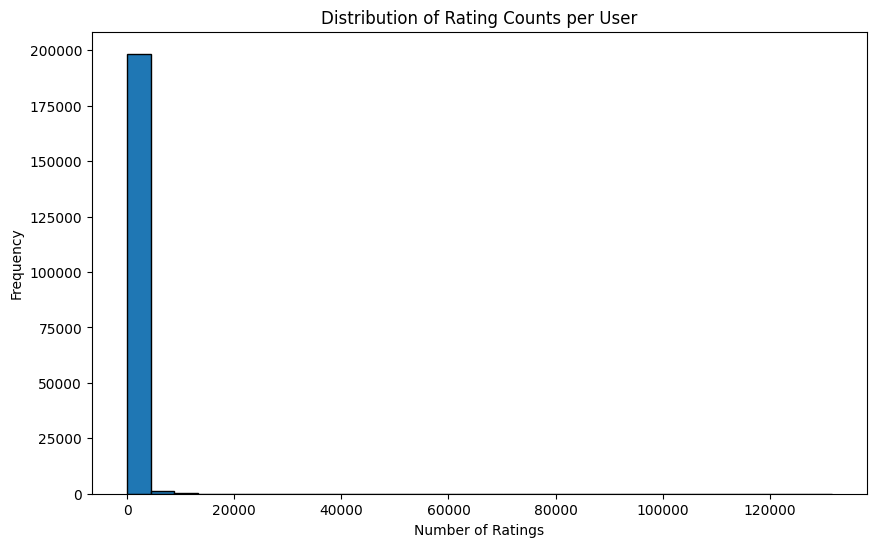

Total number of users: 200000


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

data= user_ratings_count.toPandas()

#data = user_ratings_count.select("ratings_count").rdd.flatMap(lambda x: x).collect()


plt.figure(figsize=(10, 6))
#sns.histplot(data, bins=50, kde=True)
plt.hist(data['ratings_count'], bins=30, edgecolor='black')
plt.title('Distribution of Rating Counts per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

total_users = user_ratings_count.count()
print("Total number of users:", total_users)

In [13]:
# normalization or log
# log better addresses skewness so choose log
from pyspark.sql.functions import log
user_ratings_count[user_ratings_count['ratings_count'] == 0].count() # no zero
user_ratings_count = user_ratings_count.withColumn('log_ratings_count', log(user_ratings_count['ratings_count']))  
user_ratings_count.show()

+-------+-------------+------------------+
|user_id|ratings_count| log_ratings_count|
+-------+-------------+------------------+
| 400003|          256| 5.545177444479562|
| 400129|           50| 3.912023005428146|
| 400152|           98| 4.584967478670572|
| 400301|          365|5.8998973535824915|
| 400440|           26| 3.258096538021482|
| 400612|           57|  4.04305126783455|
| 400735|          302|  5.71042701737487|
| 400797|          151| 5.017279836814924|
| 400833|           59|  4.07753744390572|
| 400982|          677| 6.517671272912275|
| 401161|           28| 3.332204510175204|
| 401778|           33|3.4965075614664802|
| 401880|          393| 5.973809611869261|
| 401901|          668| 6.504288173536645|
| 402253|          151| 5.017279836814924|
| 402643|         2173|7.6838639802564295|
| 402896|          130| 4.867534450455582|
| 403340|         7566| 8.931419805192975|
| 403389|         1011| 6.918695219020472|
| 403422|           23|3.1354942159291497|
+-------+--

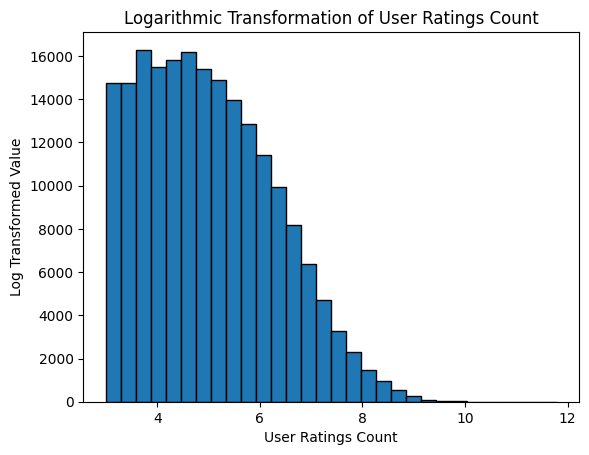

In [14]:
import matplotlib.pyplot as plt

user_ratings_count_p = user_ratings_count.toPandas()

plt.hist(user_ratings_count_p['log_ratings_count'], bins=30, edgecolor='black')
plt.title('Logarithmic Transformation of User Ratings Count')
plt.xlabel('User Ratings Count')
plt.ylabel('Log Transformed Value')
plt.show()

In [15]:
from pyspark.sql.functions import log, col, abs, mean, stddev

mean_log = user_ratings_count.select(mean(col("log_ratings_count"))).collect()[0][0]
stddev_log = user_ratings_count.select(stddev(col("log_ratings_count"))).collect()[0][0]

user_ratings_count = user_ratings_count.withColumn("z_score", (col("log_ratings_count") - mean_log) / stddev_log)
user_ratings_count = user_ratings_count.withColumn("is_outlier", abs(col("z_score")) > 3) # threshold 3


In [16]:
user_ratings_count_cleaned = user_ratings_count.filter(col("is_outlier") == False)
print("Original DataFrame:", user_ratings_count.count())
print("Cleaned DataFrame (without outliers):", user_ratings_count_cleaned.count())

Original DataFrame: 200000


Cleaned DataFrame (without outliers): 199593


In [17]:
user_ratings_count_cleaned_df = df.join(user_ratings_count_cleaned.select("user_id"), on="user_id", how="inner")
user_ratings_count_cleaned_df.show()

+-------+--------+-------+------+--------+---------+-----------+
|user_id|genre_id|song_id|rating|album_id|artist_id| genre_name|
+-------+--------+-------+------+--------+---------+-----------+
| 400003|       0|    909|     5|   12325|     7868|    Unknown|
| 400003|       0|   1078|     4|   15269|      443|    Unknown|
| 400003|       0|   1244|     4|    4257|     6918|    Unknown|
| 400003|       0|   3245|     3|   14647|     8510|    Unknown|
| 400003|       0|   3378|     4|    1574|     1926|    Unknown|
| 400003|       0|   5279|     5|   12268|     8543|    Unknown|
| 400003|       0|   5448|     4|   12886|     7092|    Unknown|
| 400003|       0|   7351|     4|    3442|     7254|    Unknown|
| 400003|       0|   7475|     5|   18801|     5187|    Unknown|
| 400003|     106|   9802|     3|    2136|     2640|        Pop|
| 400003|       0|  11832|     5|   16836|     3279|    Unknown|
| 400003|       0|  12383|     4|   10938|     9123|    Unknown|
| 400003|       0|  13370

In [18]:
user_ratings_count_cleaned_df.count()

72421169

In [19]:
## IQR way instead of log

In [20]:
quantiles = user_ratings_count.approxQuantile("ratings_count", [0.25, 0.75], 0.05)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

filtered_df = user_ratings_count.filter((col("ratings_count") >= lower_bound) & (col("ratings_count") <= upper_bound))

print("Data without Outliers:", filtered_df.count())

Data without Outliers: 173463


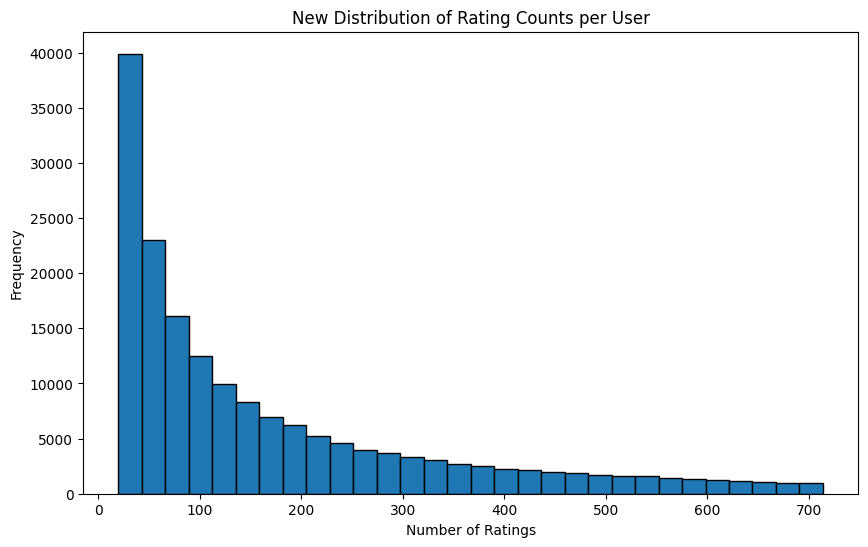

In [21]:
filtered_df_data= filtered_df.toPandas()

plt.figure(figsize=(10, 6))
#sns.histplot(data, bins=50, kde=True)
plt.hist(filtered_df_data['ratings_count'], bins=30, edgecolor='black')
plt.title('New Distribution of Rating Counts per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

In [22]:
filtered_df_new = df.join(filtered_df.select("user_id"), on="user_id", how="inner")
print("new dataset count", filtered_df_new.count())

new dataset count 29381421


In [23]:
# remove users instead?

In [24]:
# 0 - 800 reviews in first two bin
#new_filtered = user_ratings_count.filter(user_ratings_count['ratings_count'] <= 800)
#new_filtered.count()

In [25]:
#final_filtered_df = df.join(new_filtered.select("user_id"), on="user_id", how="inner")

In [26]:
#final_filtered_df.show()